<a href="https://colab.research.google.com/github/ssv273/computer_vision/blob/master/HW_06_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Обучить сиамскую сеть для верификации лиц на датасете LFW

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

from tqdm.notebook import tqdm

from collections import Counter

In [0]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]']
)

In [3]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

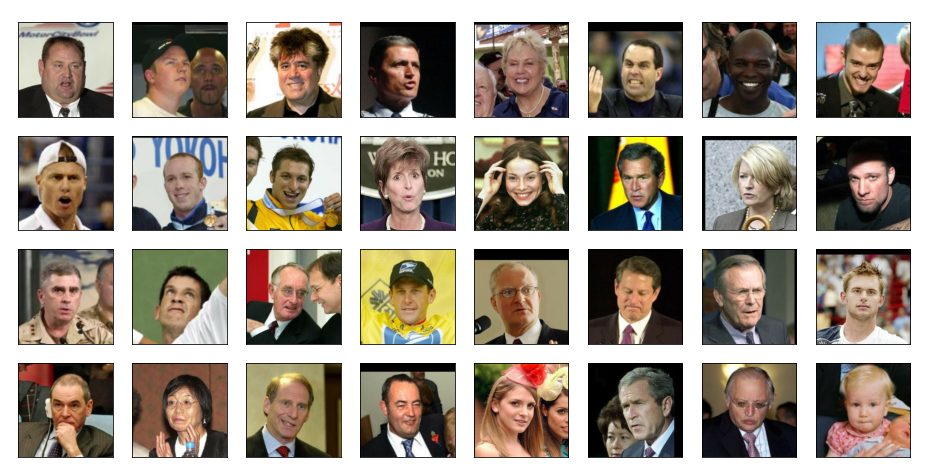

In [4]:
some_samples = [[x[1], x[0]] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16,8))
for i in range(len(some_samples)):
  ax = fig.add_subplot(4, 8, i + 1)
  ax.imshow(some_samples[i][0])
  ax.set_title(some_samples[i][1].numpy().decode('utf-8'), c='w')
  plt.xticks([]), plt.yticks([])
plt.show()

Посмотрим на размер нашего датасета

In [5]:
train_ds_shape = tf.data.experimental.cardinality(train_ds).numpy()
train_ds_shape

11910

### Для наглядгости выберем N человек с наибольшим количеством фотографий

In [0]:
N = 10
# N = train_ds_shape

In [7]:
names_list = [x[0].numpy().decode('utf-8') for x in iter(train_ds.take(train_ds_shape))]
len(names_list)

11910

In [0]:
most_common_names = Counter(names_list).most_common(N)

In [9]:
summ_photos = 0
for mcn in most_common_names:
    summ_photos += mcn[1]
    
summ_photos                   # общее количество отобранных фото

1319

In [10]:
most_common_names_list = []
for name in most_common_names:
    most_common_names_list.append(name[0])

len(most_common_names_list)

10

In [0]:
MAP_SET = {}
for iterations, names in enumerate(most_common_names_list):
    MAP_SET[names] =  iterations

### Теперь выберем из датасета фото с этими людьми

In [0]:
lst_train_ds = list(train_ds.as_numpy_iterator())

In [13]:
len(lst_train_ds)

11910

In [14]:
new_dataset_list = []
for examples in tqdm(lst_train_ds):
    if examples[0].decode('utf8') in most_common_names_list:
        new_dataset_list.append(examples)

Проверим совпадают ли размеры

In [15]:
len(new_dataset_list) == summ_photos

True

#### Теперь заменим строки в labels на значения из словаря

In [16]:
for n in tqdm(range(len(new_dataset_list))):
    new_dataset_list[n] = list(new_dataset_list[n])
    new_dataset_list[n][0] = np.array(MAP_SET[new_dataset_list[n][0].decode('utf8')])

### Создадим numpy массивы 

In [17]:
train_x = new_dataset_list[0][1].reshape(-1, 250, 250, 3)
train_y = [new_dataset_list[0][0]]
for imgs in tqdm(new_dataset_list[1:]):
    train_x = np.vstack((train_x, imgs[1].reshape(-1, 250, 250, 3)))
    train_y.append(imgs[0])

In [18]:
train_y = np.array(train_y)
train_x.shape, train_y.shape

((1319, 250, 250, 3), (1319,))

проверим всё ли мы правильно сделали

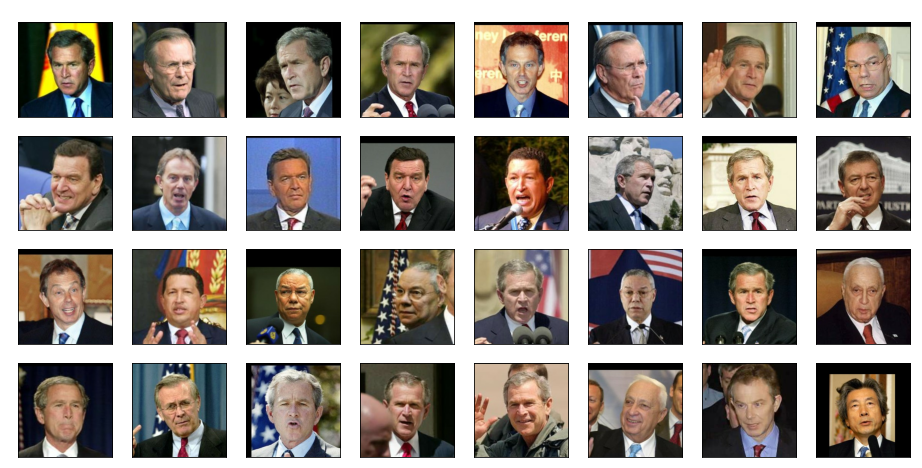

In [19]:
fig = plt.figure(figsize=(16,8))
for i in range(32):
    ax = fig.add_subplot(4, 8, i + 1)
    ax.imshow(train_x[i])
    ax.set_title(list(MAP_SET.keys())[list(MAP_SET.values()).index(train_y[i])], c='w')
    plt.xticks([]), plt.yticks([])
plt.show()

Вроде всё верно

итак, у нас есть свои данные, построим из них датасет

### Создание датасета

Приведём к формату 0:1

In [0]:
train_x = train_x.astype(np.float32) / 255.

In [0]:
BATCH_SIZE = 64
NUM_EPOCHS = 100

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

### Создадим модель

In [0]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [0]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

### Contrastive Loss

In [0]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Обучение модели

In [26]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    
    if iteration % 50 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 80.53010559082031
[50] Loss: 41.39609909057617
[100] Loss: 18.101591110229492
[150] Loss: 24.299976348876953
[200] Loss: 11.532342910766602
[250] Loss: 18.375350952148438
[300] Loss: 19.424814224243164
[350] Loss: 14.170373916625977
[400] Loss: 18.328086853027344
[450] Loss: 12.577457427978516
[500] Loss: 5.465322494506836
[550] Loss: 8.300740242004395
[600] Loss: 9.706321716308594
[650] Loss: 5.76609468460083
[700] Loss: 7.5125956535339355
[750] Loss: 4.074345588684082
[800] Loss: 4.381568908691406
[850] Loss: 3.0899300575256348
[900] Loss: 2.4065637588500977
[950] Loss: 2.5985848903656006
[1000] Loss: 4.341780662536621
[1050] Loss: 3.5013833045959473
[1100] Loss: 3.8481247425079346
[1150] Loss: 3.6962342262268066
[1200] Loss: 3.0563650131225586
[1250] Loss: 1.8796833753585815
[1300] Loss: 1.8112025260925293
[1350] Loss: 1.1301251649856567
[1400] Loss: 1.7534466981887817
[1450] Loss: 2.0223240852355957
[1500] Loss: 3.067869186401367
[1550] Loss: 1.0942357778549194
[1600] Los

## Получим эмбеддинги

In [0]:
embs = model(train_x[:500])

## Функция для визуализации эмбеддингов

In [0]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for class_idx in range(np.max(targets)+1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    plt.legend(labels, loc='best')
    plt.grid(True)

## Визуализация образцов 2D пространстве с помощью TSNE

In [0]:
test_x_flat = train_x.reshape(-1, 250*250*3)
test_x_2D = TSNE(n_components=2).fit_transform(test_x_flat[:500])
labels_for_viz = train_y[:500]

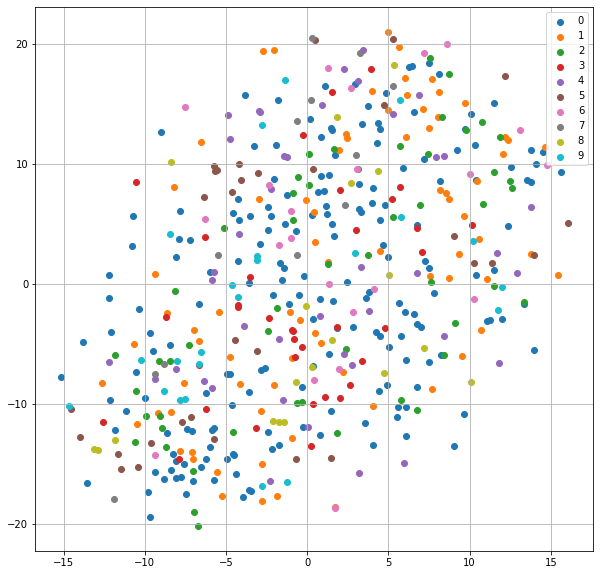

In [30]:
draw_embeddings(test_x_2D, labels_for_viz, list(range(10)))

## Визуализация эмбеддингов в 2D пространстве с помощью TSNE

In [0]:
test_embs_2D = TSNE(n_components=2).fit_transform(embs)
labels_for_viz = train_y[:500]

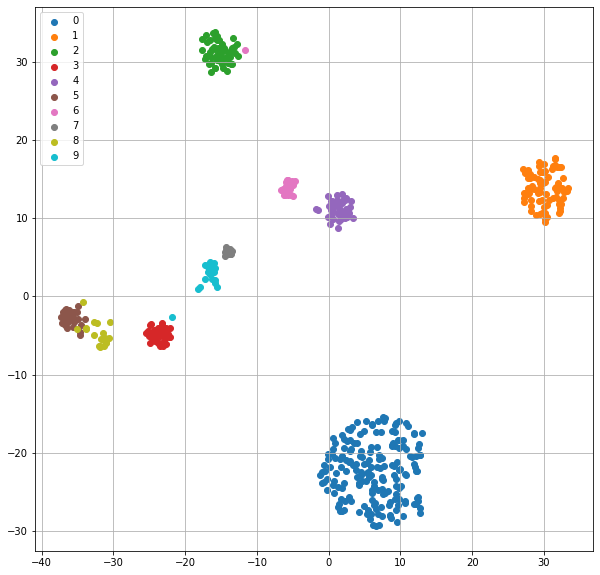

In [32]:
draw_embeddings(test_embs_2D, labels_for_viz, list(range(10)))

# Посмотрим как это работает на своих изображениях

In [33]:
!wget https://raw.githubusercontent.com/ssv273/computer_vision/master/photo1.png
!wget https://raw.githubusercontent.com/ssv273/computer_vision/master/photo2.png
!wget https://raw.githubusercontent.com/ssv273/computer_vision/master/photo3.png

--2020-04-28 01:11:24--  https://raw.githubusercontent.com/ssv273/computer_vision/master/photo1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 408922 (399K) [image/png]
Saving to: ‘photo1.png’

photo1.png          100%[===================>] 399.34K  --.-KB/s    in 0.06s   

2020-04-28 01:11:25 (6.21 MB/s) - ‘photo1.png’ saved [408922/408922]

--2020-04-28 01:11:27--  https://raw.githubusercontent.com/ssv273/computer_vision/master/photo2.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 495034 (483K) [image/png]
Saving to: ‘photo2.png

In [0]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250, 3), mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (250, 250, 3))
    return img

In [0]:
img_a1 = load_and_prepare_image('photo1.png')
img_a2 = load_and_prepare_image('photo2.png')
img_b = load_and_prepare_image('photo3.png')

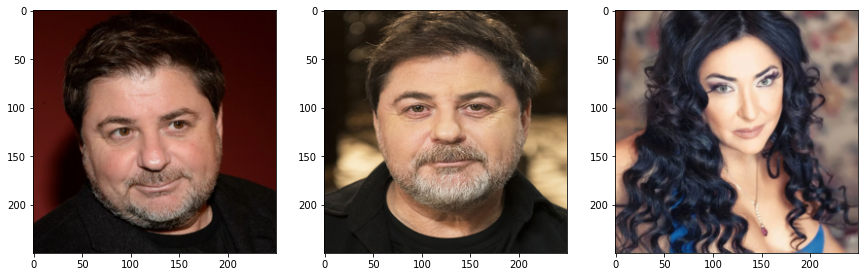

In [36]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(img_a1)
ax = fig.add_subplot(1, 4, 2)
ax.imshow(img_a2)
ax = fig.add_subplot(1, 4, 3)
ax.imshow(img_b)

plt.show()

In [0]:
new_embs = model(np.stack((img_a1, img_a2, img_b), axis=0))

In [0]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

In [0]:
emb1 = new_embs[0,:] #a
emb2 = new_embs[1,:] #a
emb3 = new_embs[2,:] #b

In [79]:
print('Расстояние между фото Цекало №1 и №2 = {}'.format(diff(emb1, emb2)))
print('Расстояние между фото Цекало №1 и фото Лолиты = {}'.format(diff(emb1, emb3)))
print('Расстояние между фото Цекало №2 и фото Лолиты = {}'.format(diff(emb2, emb3)))

Расстояние между фото Цекало №1 и №2 = 13.47819736460402
Расстояние между фото Цекало №1 и фото Лолиты = 7.126589681401655
Расстояние между фото Цекало №2 и фото Лолиты = 13.076345598407238


Конечно разница между эмбеддингами получилась небольшая, но и сеть мы обучали всего на 10 лицах

# Теперь обучим на всем датасете и посмотрим на изменения

In [0]:
# еще раз загрузим датасет
(train_ds, test_ds), ds_info = tfds.load(
    'lfw', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]']
)

In [0]:
# напишем функцию нормализации
def normalize_example(label, image):
    return label, tf.cast(image, tf.float32) / 255.

In [0]:
BATCH_SIZE = 64
NUM_EPOCHS = 50

train_ds = train_ds.map(normalize_example)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

и обучим модель

In [0]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [64]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 9.395581245422363
[200] Loss: 54.712303161621094
[400] Loss: 0.0
[600] Loss: 0.026674650609493256
[800] Loss: 0.0
[1000] Loss: 0.22681167721748352
[1200] Loss: 0.6724482178688049
[1400] Loss: 13.405548095703125
[1600] Loss: 0.0
[1800] Loss: 0.0
[2000] Loss: 0.0
[2200] Loss: 0.10329042375087738
[2400] Loss: 0.3589697778224945
[2600] Loss: 0.0
[2800] Loss: 0.9014553427696228
[3000] Loss: 0.0006733753834851086
[3200] Loss: 0.0
[3400] Loss: 0.00010675119119696319
[3600] Loss: 0.0
[3800] Loss: 0.03834144398570061
[4000] Loss: 0.3014107942581177
[4200] Loss: 0.6445907950401306
[4400] Loss: 0.0
[4600] Loss: 0.04687265679240227
[4800] Loss: 0.14476411044597626
[5000] Loss: 0.016013354063034058
[5200] Loss: 0.15656894445419312
[5400] Loss: 0.012172113172709942
[5600] Loss: 0.0
[5800] Loss: 3.4272725582122803
[6000] Loss: 0.11847759783267975
[6200] Loss: 0.0
[6400] Loss: 0.4332095980644226
[6600] Loss: 0.31805509328842163
[6800] Loss: 0.07691052556037903
[7000] Loss: 0.0
[7200] Loss: 0

### посмотрим теперь на эмбеддинги предыдущих фото

In [0]:
emb_a1 = model(img_a1.reshape(-1, 250, 250, 3))
emb_a2 = model(img_a2.reshape(-1, 250, 250, 3))
emb_b = model(img_b.reshape(-1, 250, 250, 3))

In [75]:
print('Расстояние между фото Цекало №1 и №2 = {}'.format(diff(emb_a1, emb_a2)))
print('Расстояние между фото Цекало №1 и фото Лолиты = {}'.format(diff(emb_a1, emb_b)))
print('Расстояние между фото Цекало №2 и фото Лолиты = {}'.format(diff(emb_a2, emb_b)))

Расстояние между фото Цекало №1 и №2 = 8.100791195504552
Расстояние между фото Цекало №1 и фото Лолиты = 16.047640446994556
Расстояние между фото Цекало №2 и фото Лолиты = 14.55177114921416


как мы видим модель уже гораздо лучше разнесла эмбеддинги разных классов на разные расстояния, даже на изображениях, которые она никогда не видела

In [68]:
diff(emb_a1, emb_b)

16.047640446994556

In [69]:
diff(emb2, emb_b)

31.113023039182785